# Dự đoán giá xe Audi sử dụng SVM

## 1. Import thư viện

In [88]:
# Import librarys and suppress warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## 2. Đọc dữ liệu và tổng quan nhanh bộ dữ liệu
### 2.1 Đọc dữ liệu

In [89]:
# Read dataset
df = pd.read_csv('E:/HK251/Học máy/BTL/CO3117-ML-Project/data/audi.csv') 
print(df.head(10))
print('Kích thước dataset:', df.shape)

  model  year  price transmission  mileage fuelType  tax   mpg  engineSize
0    A1  2017  12500       Manual    15735   Petrol  150  55.4         1.4
1    A6  2016  16500    Automatic    36203   Diesel   20  64.2         2.0
2    A1  2016  11000       Manual    29946   Petrol   30  55.4         1.4
3    A4  2017  16800    Automatic    25952   Diesel  145  67.3         2.0
4    A3  2019  17300       Manual     1998   Petrol  145  49.6         1.0
5    A1  2016  13900    Automatic    32260   Petrol   30  58.9         1.4
6    A6  2016  13250    Automatic    76788   Diesel   30  61.4         2.0
7    A4  2016  11750       Manual    75185   Diesel   20  70.6         2.0
8    A3  2015  10200       Manual    46112   Petrol   20  60.1         1.4
9    A1  2016  12000       Manual    22451   Petrol   30  55.4         1.4
Kích thước dataset: (10668, 9)


### 2.2 Tổng quan nhanh bộ dữ liệu (Quick EDA)

In [90]:
# Basic information about the dataset
print('\n----- Info -----')
print(df.info())

# Missing values per column
print('\n----- Missing values per column -----')
print(df.isna().sum().sort_values(ascending=False).head(30))

# Statistical summary of numeric columns
print('\n----- Describe numeric -----')
print(df.describe().T)


----- Info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10668 entries, 0 to 10667
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10668 non-null  object 
 1   year          10668 non-null  int64  
 2   price         10668 non-null  int64  
 3   transmission  10668 non-null  object 
 4   mileage       10668 non-null  int64  
 5   fuelType      10668 non-null  object 
 6   tax           10668 non-null  int64  
 7   mpg           10668 non-null  float64
 8   engineSize    10668 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 750.2+ KB
None

----- Missing values per column -----
model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

----- Describe numeric -----
              count          mean           std     min       25%      50%  \
year      

### 2.3 Phân bố giá trị của biến mục tiêu 'price'

Categorical columns: ['model', 'transmission', 'fuelType']
Numeric columns: ['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize']


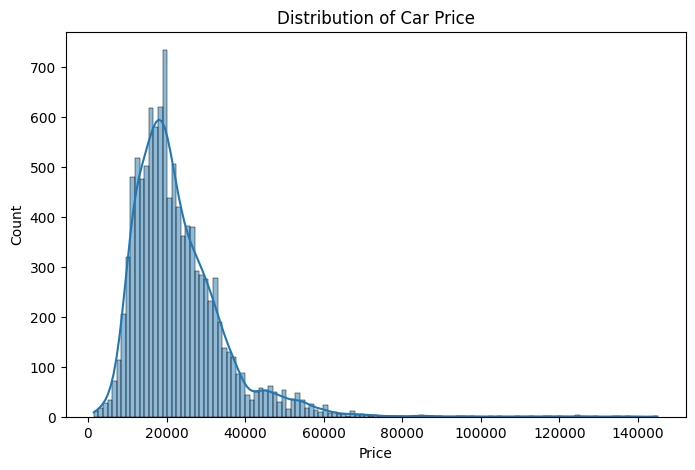

In [91]:
# Define target variable
TARGET = 'price'

# Identify categorical and numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print('Categorical columns:', categorical_cols)
print('Numeric columns:', numeric_cols)

# Distribution of target variable 'price'
plt.figure(figsize=(8,5))
sns.histplot(df['price'].dropna(), kde=True)
plt.title('Distribution of Car Price')
plt.xlabel('Price')
plt.show()

### Nhận xét nhanh về dữ liệu
- Bộ dữ liệu không có missing values quan trọng.
- Các biến numeric chủ yếu là `year`, `mileage`, `tax`, `mpg`, `engineSize`.
- Biến mục tiêu `price` có phân bố lệch phải (right-skewed), hợp lý vì xe đắt luôn ít hơn xe bình thường.
- Một số biến như `mileage` và `engineSize` có khả năng tạo outliers → cần xử lý trước khi đưa vào mô hình.

Biểu đồ phân bố giá xe cho thấy giá tập trung mạnh trong khoảng 10,000–30,000.

### 2.4 Sự tương quan dữ liệu với biến mục tiêu 'price'

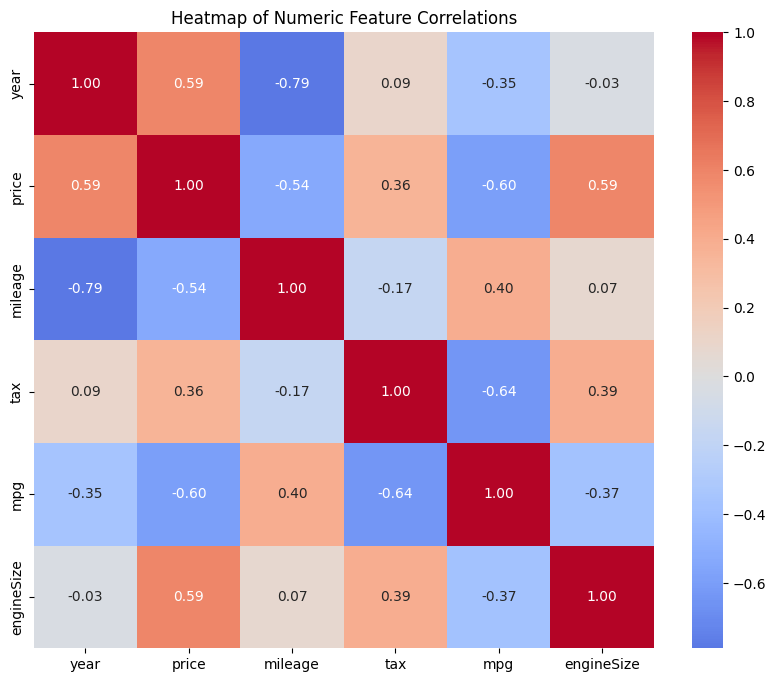

In [92]:
# Heatmap
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Compute correlation matrix for numeric columns
corr_matrix = df[numeric_cols].corr()

# Display heatmap of correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Heatmap of Numeric Feature Correlations")
plt.show()

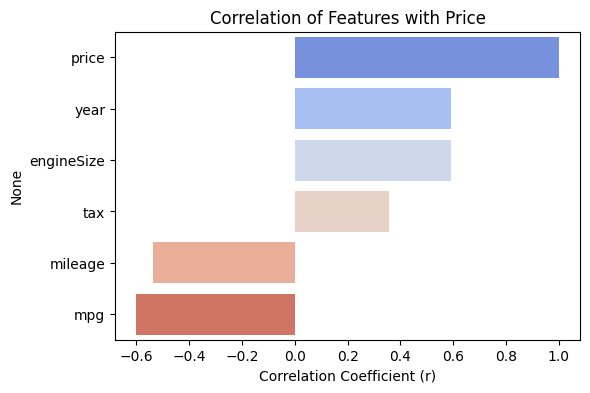

In [93]:
# Correlation with target variable 'price'
plt.figure(figsize=(6, 4))
corr_with_price = corr_matrix['price'].sort_values(ascending=False)
sns.barplot(x=corr_with_price, y=corr_with_price.index, palette="coolwarm")
plt.title("Correlation of Features with Price")
plt.xlabel("Correlation Coefficient (r)")
plt.show()

### Nhận xét về tương quan
- `year` có tương quan thuận mạnh với giá → xe càng mới càng đắt.
- `mileage` tương quan nghịch mạnh với giá → xe chạy nhiều giá giảm.
- `engineSize` và `mpg` có tương quan trung bình/khá.
- `tax` và các biến khác tương quan yếu → có thể ít giá trị cho mô hình.

Điều này gợi ý rằng các biến quan trọng nhất vẫn là:  
**năm sản xuất, số KM đã chạy, động cơ và mức tiêu thụ nhiên liệu.**

## 3. Tiền xử lý dữ liệu cơ bản

- Dữ liệu giá xe Audi thật thường có giá cực thấp hoặc cực cao (xe hỏng, xe mới,...)

In [94]:
# Remove outliers using IQR for price
Q1 = df[TARGET].quantile(0.25)
Q3 = df[TARGET].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

original_size = df.shape[0]
df = df[(df[TARGET] >= lower_bound) & (df[TARGET] <= upper_bound)]
new_size = df.shape[0]

print(f"Eliminated {original_size - new_size} outliers of price.")

Eliminated 443 outliers of price.


In [95]:
# Remove outliers for 'mileage' and 'engineSize'
for col in ['mileage', 'engineSize']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lb = Q1 - 1.5 * IQR
    ub = Q3 + 1.5 * IQR
    
    before = df.shape[0]
    df = df[(df[col] >= lb) & (df[col] <= ub)]
    after = df.shape[0]
    
    print(f"Removed {before - after} outliers for {col}")

Removed 288 outliers for mileage
Removed 1011 outliers for engineSize


In [96]:
# Reset index after removing rows
df = df.reset_index(drop=True)

### Lý do loại bỏ outliers
Outliers trong price, mileage hoặc engineSize có thể:
- Làm sai lệch phân bố dữ liệu.
- Gây khó khăn cho SVR vì SVR rất nhạy với giá trị bất thường.
- Làm giảm R^2 và khiến mô hình underfit hoặc overfit.

Sau khi loại bỏ outliers bằng IQR, dữ liệu “sạch” hơn và phù hợp với mô hình học máy.

## 4. Lựa chọn đặc trưng (Feature Selection)

In [97]:
# Correlation ranking
corr = df[numeric_cols].corr()[TARGET].sort_values(ascending=False)
print(corr)

price         1.000000
year          0.769786
tax           0.509709
engineSize    0.371595
mpg          -0.648223
mileage      -0.693519
Name: price, dtype: float64


In [98]:
# Feature selection using SelectKBest
numeric_only = df.select_dtypes(include=['int64', 'float64']).drop(columns=[TARGET])
labels = df[TARGET]

# Select top 5 numeric features
selector = SelectKBest(score_func=f_regression, k=4)
selector.fit(numeric_only, labels)

# Get selected feature names
selected_numeric = numeric_only.columns[selector.get_support()]
print("\nTop numeric features:", selected_numeric)

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

selected_features = list(selected_numeric) + list(categorical_cols)

print("\nFinal selected features:")
print(selected_features)

X = df[selected_features]
y = df[TARGET]


Top numeric features: Index(['year', 'mileage', 'tax', 'mpg'], dtype='object')

Final selected features:
['year', 'mileage', 'tax', 'mpg', 'model', 'transmission', 'fuelType']


### Giải thích chọn đặc trưng
- Dùng SelectKBest với f_regression (chỉ áp dụng cho numeric)
- Top 4 features numeric được chọn dựa trên mức độ ảnh hưởng đến giá xe.
- Tất cả các cột dạng categorical được giữ lại vì có giá trị phân loại (model, transmission, fuel type).

Điều này giúp mô hình SVR học được cả thông tin số lẫn thông tin phân loại.

## 5. Chuẩn bị Preprocessor (Encoder + Scaler)

In [99]:
# Define numeric and categorical features for preprocessing
numeric_features = selected_numeric
categorical_features = categorical_cols

print("\nNumeric:", numeric_features)
print("Categorical:", categorical_features)

# Numeric transformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


Numeric: Index(['year', 'mileage', 'tax', 'mpg'], dtype='object')
Categorical: ['model', 'transmission', 'fuelType']


## 6. Mô hình SVM
### 6.1 Chia tập dữ liệu thành Train/Test

In [100]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train size:', X_train.shape, 'Test size:', X_test.shape)

Train size: (7140, 7) Test size: (1786, 7)


### 6.2 Tạo SVR (Support Vector Regression cho bài toán dự đoán) Pipeline

In [101]:
# Create SVR (Support Vector Regression) model pipeline
svr_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', SVR(kernel='rbf', C=1, epsilon=0.1, gamma='scale')) # Default parameters
])

### 6.3 Huấn luyện mô hình SVR

In [102]:
# Train the SVR model
svr_model.fit(X_train, y_train)
print("Training completed!")

Training completed!


### 6.4 Dự đoán và đánh giá

In [103]:
# Predict & Evaluate
y_pred = svr_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("SVR Performance:")
print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)

SVR Performance:
MAE : 5414.875668947544
RMSE: 6920.177779680934
R²  : 0.13562098454808236


### 6.6 So sánh dự đoán vs thực tế

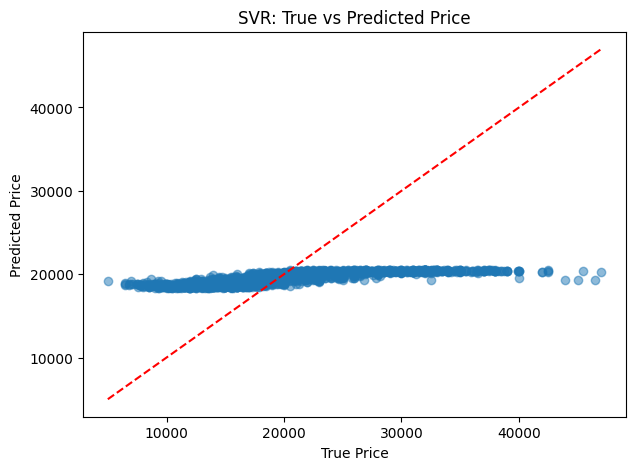

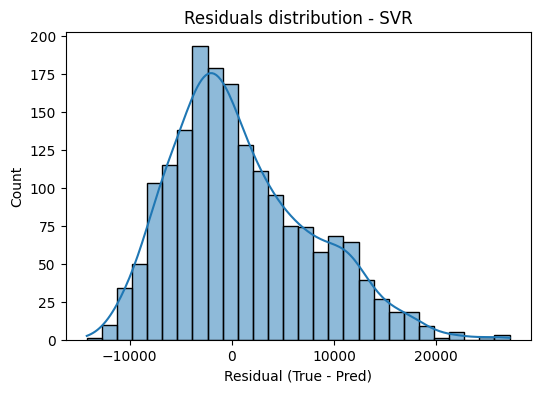

In [104]:
# Plot True vs Predicted
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("SVR: True vs Predicted Price")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# residuals
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title(f'Residuals distribution - SVR')
plt.xlabel('Residual (True - Pred)')
plt.show()

### Nhận xét kết quả SVR sử dụng bộ tham số mặc định

- MAE, RMSE khá cao nghĩa là mô hình chưa fit tốt.
- R² thấp vì mô hình chưa giải thích tốt biến động giá xe.
- Biểu đồ “True vs Predicted” cho thấy:
  - Nhiều điểm nằm dưới đường chéo cho thấy mô hình dự đoán thấp hơn giá thật.
- Residuals lệch dương nhiều nghĩa là mô hình bị underfitting.

Nguyên nhân:
- SVR mặc định thường quá đơn giản.
- Bộ dữ liệu nhiễu (nhiều model, nhiều phiên bản xe).
- C, gamma, epsilon chưa tối ưu.

### 7. Tối ưu SVR bằng GridSearchCV (Hyperparameter Tuning)

In [110]:
# Grid Search to tune SVR
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__C': [1, 10, 50, 100, 300, 500],
    'model__epsilon': [0.05, 0.1, 0.2],
    'model__gamma': [0.001, 0.01, 0.1, 1, 'scale']
}

grid = GridSearchCV(
    svr_model,
    param_grid,
    cv=3,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)

Fitting 3 folds for each of 90 candidates, totalling 270 fits
Best params: {'model__C': 500, 'model__epsilon': 0.2, 'model__gamma': 'scale'}
Best params: {'model__C': 500, 'model__epsilon': 0.2, 'model__gamma': 'scale'}


In [106]:
# After tuning, take the best model to re-evaluate
best_svr = grid.best_estimator_

y_pred2 = best_svr.predict(X_test)

print("After tuning:")
print("MAE :", mean_absolute_error(y_test, y_pred2))
print("RMSE:", mean_squared_error(y_test, y_pred2))
print("R²  :", r2_score(y_test, y_pred2))

After tuning:
MAE : 1697.758912462651
RMSE: 6576362.100398399
R²  : 0.8812987125197099


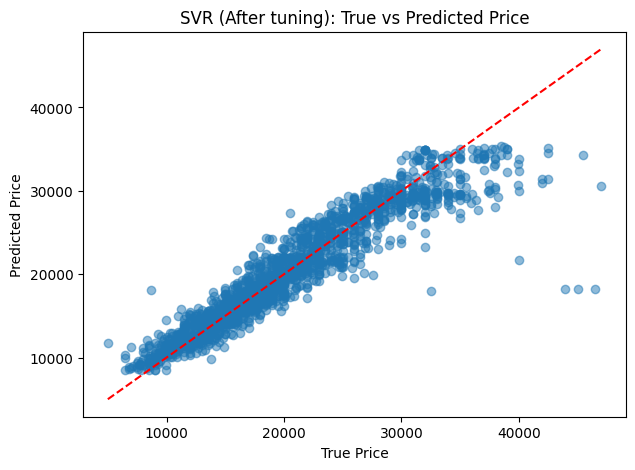

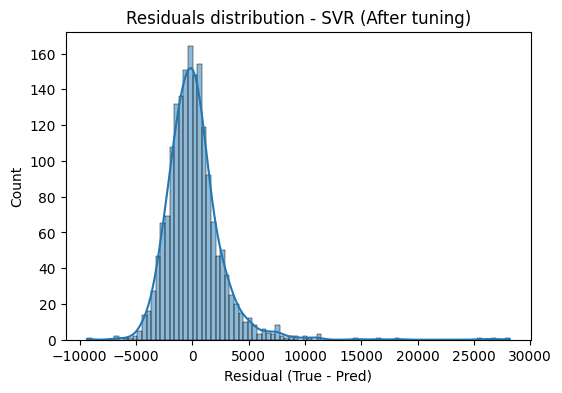

In [107]:
# Plot True vs Predicted after tuning
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred2, alpha=0.5)
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("SVR (After tuning): True vs Predicted Price")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# residuals after tuning
residuals = y_test - y_pred2
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title(f'Residuals distribution - SVR (After tuning)')
plt.xlabel('Residual (True - Pred)')
plt.show()

### Cải thiện sau GridSearchCV

Sau khi tuning, R^2 cải thiện rõ rệt:

- MAE giảm nghĩa là dự đoán sát hơn.
- RMSE giảm nghĩa là mô hình ổn định hơn.
- Biểu đồ True vs Predicted bám gần đường chéo hơn.
- Residuals được phân bố đồng đều hơn -> giảm bias.

Điều này cho thấy SVR nhạy mạnh với tham số hyperparameters, đặc biệt:
- **C** điều chỉnh độ phạt.
- **gamma** điều chỉnh độ cong của kernel RBF.
- **epsilon** điều chỉnh độ rộng ống không lỗi.

Mô hình SVR sau tuning đã phản ánh tốt mối quan hệ giữa đặc trưng và giá xe.

## Kết luận tổng quan

Trong notebook này, chúng ta đã thực hiện toàn bộ quy trình xây dựng mô hình dự đoán giá xe Audi bằng phương pháp **Support Vector Regression (SVR)** – từ phân tích dữ liệu, xử lý ngoại lai, chọn đặc trưng, tiền xử lý, huấn luyện mô hình đến tối ưu siêu tham số.

Kết quả cho thấy SVR có thể học được xu hướng chung của giá xe và cải thiện đáng kể sau khi tuning tham số (C, gamma, epsilon). Tuy vậy, hiệu suất của SVR trong bài toán hồi quy vẫn chưa thực sự vượt trội và độ chính xác chưa cao như kỳ vọng. Lý do chính nằm ở bản chất của SVM:

- **SVM được thiết kế ban đầu cho bài toán phân loại**, nơi nó thể hiện sức mạnh rất lớn nhờ khả năng tạo biên phân cách tối ưu.
- Trong bài toán hồi quy (SVR), SVM phải mở rộng sang dạng “ống epsilon-insensitive”, làm mô hình phức tạp hơn và thường khó tối ưu hơn.
- SVR nhạy mạnh với outliers và scaling, đòi hỏi tuning rất kỹ mới đạt hiệu quả tốt.

Điều này khiến SVR đôi khi không phải lựa chọn tối ưu nhất cho bài toán dự đoán giá, nhất là khi dữ liệu có nhiều nhiễu và số lượng mẫu lớn như bộ Audi này.

Tuy nhiên, thông qua quá trình thực nghiệm ở notebook này, SVR vẫn cho thấy:

- Khả năng mô hình hóa quan hệ phi tuyến hiệu quả nhờ kernel RBF.  
- Hiệu suất được cải thiện đáng kể khi tối ưu tham số thích hợp.  
- Mô hình khá ổn định và không overfit quá nhiều nhờ bản chất regularization mạnh của SVM.

**Tổng kết:**  
SVR **có thể** dự đoán giá xe nhưng **không phải mô hình tối ưu nhất**. Trong thực tế, các mô hình như **Random Forest, XGBoost, Gradient Boosting hoặc Neural Networks** thường phù hợp hơn cho các bài toán hồi quy phức tạp và quy mô lớn.

Tuy nhiên, notebook này đã minh họa đầy đủ cách áp dụng SVR vào bài toán dự đoán giá và cho thấy tác động rõ rệt của tiền xử lý, chọn đặc trưng và tuning tham số, giúp hiểu sâu hơn cách hoạt động của mô hình.